# Data Incubator Project

I am proposing an exploration of the US individual income tax statistics supplied by the IRS. The IRS has made available data on all 1040 forms collected since 2004 (and for select years prior to that). For each year, several features of the 1040 are detailed. These include items like total income tax, interst income, charitable contributions, adjusted gross income (AGI), and a variety of credits and deductions.

Within each year, the data is broken down by zip code. And within each zipcode, the returns are furhter categorized into one of six AGI ranges. The amounts on all the 1040s within a single zip code and AGI range are summed and presented in the data. This means that there are three interesting axes of variation explore: geographic (using zip codes), chronological (using the year), and economic (by AGI range). In my exploratory analysis thus far I have fixed the year to 2014 focused on the geographic and economic angles, as explained below.

For the first plot, I computed the AGI for each zip code in the database and plotted the results in order from lowest to highest. There were 27,681 zip codes in all, keeping in mind that those with very few tax returns are not included in the dataset (there are about 43,000 zip codes in total in the US). The purpose of this plot is to show that most of the wealth is generated in comparatively few zip codes. Note that the y-axis is logarithmic, showing that as we progress through the zip codes the wealth increases exponentially. A best-fit line is also shown, given by the approximate formula Log_{10} AGI = 9e-5*(zip #) + 6.8, so indeed the AGI increases exponentially. Some of this behavior can be explained by population data, but a similar pattern is shown when one uses AGI per return instead of total AGI. The residuals after subtracting out the linear behavior are worth further study. Especially at the high and low end we can see that the distribtuion deviates significantly from the fit. Finally, I plan to geographically map out the zip codes to see how location plays a role in AGI.

In the second plot I have shown how we can use the tax return data to get a glimpse into the lifestyle of different socioeconomic classes. I grouped the data by AGI range and computed the fraction of all returns that had Child Tax Credits and Additonal Child Tax Credits (the latter an extra tax credit given to poor families with children), and also the fraction of all returns that had a Foreign Tax Credit (which is given if taxes were paid to a foriegn government, whether because of foreign investments or foreign wages or any other foreign income). We clearly see that the poor and middle-class tax returns regularly receive Child Tax Credits but not Foreign Tax Credits, while the opposite is true for the rich. There is an interesting classification problem lurking here that I plan to explore: What features of the tax return can be used to predict AGI? This will touch on home mortgages, investments, charitable contributions, business ventures, and other activities in addition to Child and Foreign Tax Credits. The result will be an interesting profile of US persons as a function of income.

In summary, my preliminary analysis shows how tax return data can be used to extract socioeconomic trends. The two obvious next steps are to correlate the zip codes with actual geographic location, and to extent the analysis to the other years in the dataset. One effect I expect to see looking at previous years is the effects of the economic troubles of 2008 and the subsequent recovery.

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline

import seaborn as sns
sns.set(context = 'notebook', font_scale = 1.5, rc={'figure.figsize':(10, 6)})

In [3]:
#import data
zip2014 = pd.read_csv('../Data Incubator/2014zipcode/14zpallagi.csv')
labels = {'N1': 'num_returns', 'A00100' : 'agi'}
zip2014.rename(columns = labels, inplace = True)

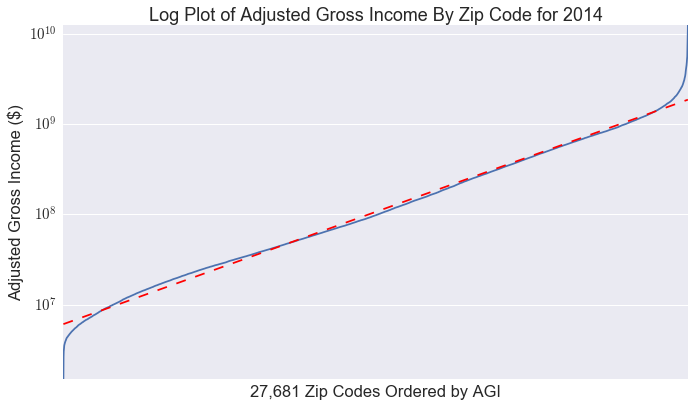

In [225]:
grouped = zip2014.groupby('zipcode', as_index=False).sum().sort_values('agi')
grouped['log_agi'] = np.log10(grouped.agi)
grouped = grouped.reset_index().log_agi

#This removes spurious entries that are assciated to the 'zip codes' 0 and 99999. 
grouped[grouped < np.log10(10**8)].plot()

plt.ylabel('Adjusted Gross Income ($)')
plt.xlabel('27,681 Zip Codes Ordered by AGI')
plt.xticks([])
plt.yticks([3,4,5,6,7],['$10^6$','$10^7$','$10^8$','$10^9$','$10^{10}$'])
plt.title('Log Plot of Adjusted Gross Income By Zip Code for 2014')

#Linear model
model = linear_model.LinearRegression()
X = np.arange(len(grouped)).reshape(len(grouped),1)
Y = grouped.values.reshape(len(grouped),1)
model.fit(X,Y)

plotrange = np.arange(len(grouped))
plt.plot(plotrange,model.predict(X),linestyle = '-', dashes = [10,10], c='r')

plt.tight_layout()
plt.savefig('zip_income.pdf')

plt.show()

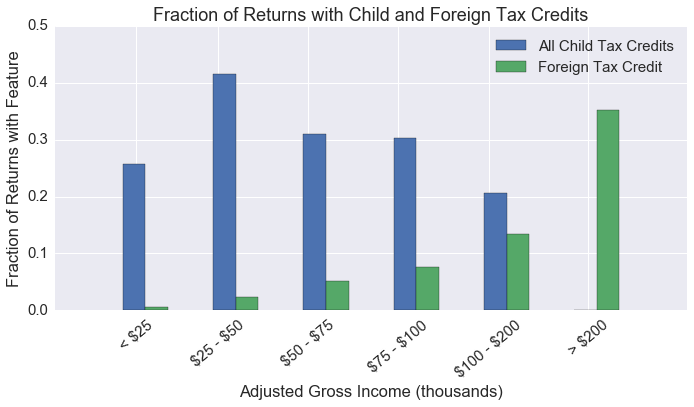

In [224]:
features = ['N07220', 'N11070', 'N07300']
info = zip2014[zip2014.num_returns > 100][['agi_stub', 'num_returns']+features]
info = info.groupby('agi_stub', as_index = True).sum()
info['All Child Tax Credits'] = info[features[0]] + info[features[1]]
info['Foreign Tax Credit'] = info[features[2]]
features = ['All Child Tax Credits','Foreign Tax Credit']
for feat in features:
    info[feat] = info[feat]/info['num_returns']
info = info[features]

info.plot(kind = 'bar', stacked = False)
plt.axis([-1,6,0,0.5])
plt.ylabel('Fraction of Returns with Feature')
plt.xlabel('Adjusted Gross Income (thousands)')
plt.xticks([-.1,.8,1.8,2.8,3.8,4.9],\
           ['< \$25','\$25 - \$50','\$50 - \$75','\$75 - \$100','\$100 - \$200','> \$200'], rotation=40)
plt.title('Fraction of Returns with Child and Foreign Tax Credits')
plt.tight_layout()

plt.savefig('feature_fractions.pdf')
plt.show()